In [173]:
import yfinance as yf
import numpy as np
import pandas as pd
import statsmodels.api as sm
import statsmodels.tsa.stattools as ts

from itertools import combinations
import matplotlib.pyplot as plt

# A. Explore relationship betwen forex pair movements etc yada yada

OK so this is not exaclty forex pairs because it seems to be a pain in the ass to find one, but i think the intuition for this one is quite solid

1. SGD is pegged against a basket of currencies (S$NEER), https://www.mas.gov.sg/monetary-policy/past-monetary-policy-decisions
2. DXY is an index that measures the USD value relative to a basket of currencies https://www.investopedia.com/terms/u/usdx.asp

Essentially this is basket meet basket kind of thing. "ETF" pairs trading if you will.

USD-SGD is tradeable, and so is DXY. Prof Ben say pairs trading does not have to be same asset class, so this COULD be legit

Anyway general steps 

1. test your series (plural) are cointegrated or not
2. test your spread is stationary or not
3. generate trading signal

Possible improvement can be done for the regression part to obtain the weights. Right now we are using OLS and probably can be changed

In [174]:
start_date = "2015-01-01"
end_date = "2022-12-31"

In [175]:
# get close data
usd_sgd_data = yf.Ticker("USDSGD=X").history(start=start_date, end=end_date)["Close"]
dxy_data = yf.Ticker("DX-Y.NYB").history(start=start_date, end=end_date)["Close"]

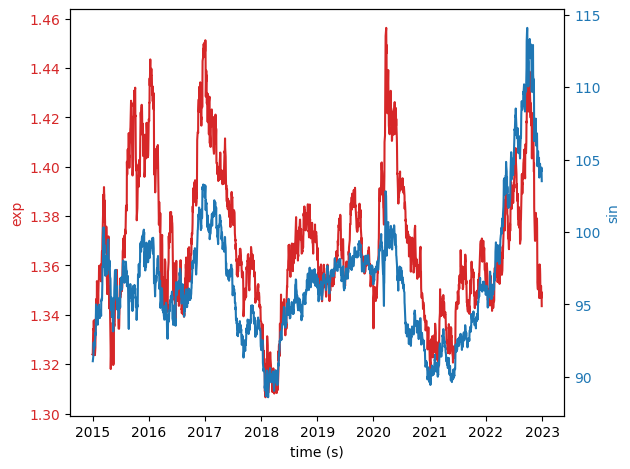

In [176]:
fig, ax1 = plt.subplots()

color = "tab:red"
ax1.set_xlabel("time (s)")
ax1.set_ylabel("exp", color=color)
ax1.plot(usd_sgd_data, color=color)
ax1.tick_params(axis="y", labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second Axes that shares the same x-axis

color = "tab:blue"
ax2.set_ylabel("sin", color=color)  # we already handled the x-label with ax1
ax2.plot(dxy_data, color=color)
ax2.tick_params(axis="y", labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

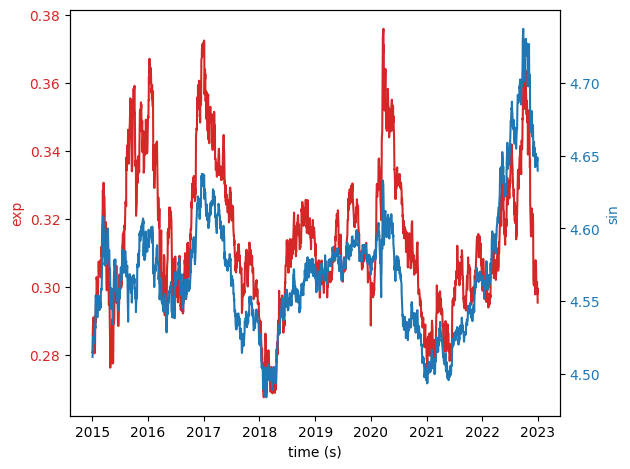

In [177]:
fig, ax1 = plt.subplots()

color = "tab:red"
ax1.set_xlabel("time (s)")
ax1.set_ylabel("exp", color=color)
ax1.plot(np.log(usd_sgd_data), color=color)
ax1.tick_params(axis="y", labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second Axes that shares the same x-axis

color = "tab:blue"
ax2.set_ylabel("sin", color=color)  # we already handled the x-label with ax1
ax2.plot(np.log(dxy_data), color=color)
ax2.tick_params(axis="y", labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

In [178]:
df_together = pd.DataFrame(
    zip(usd_sgd_data, dxy_data), index=dxy_data.index, columns=["usdsgd", "dxy"]
)


df_together

,usdsgd,dxy
Date,,
2015-01-02 00:00:00-05:00,1.32390,91.080002
2015-01-05 00:00:00-05:00,1.32378,91.379997
2015-01-06 00:00:00-05:00,1.33425,91.500000
2015-01-07 00:00:00-05:00,1.33430,91.889999
2015-01-08 00:00:00-05:00,1.33402,92.370003
...,...,...
2022-12-23 00:00:00-05:00,1.40920,104.309998
2022-12-27 00:00:00-05:00,1.40560,104.180000
2022-12-28 00:00:00-05:00,1.40742,104.459999


In [179]:
return_df = (df_together / df_together.shift(1)) - 1
return_df

,usdsgd,dxy
Date,,
2015-01-02 00:00:00-05:00,NaN,NaN
2015-01-05 00:00:00-05:00,-0.000091,0.003294
2015-01-06 00:00:00-05:00,0.007909,0.001313
2015-01-07 00:00:00-05:00,0.000038,0.004262
2015-01-08 00:00:00-05:00,-0.000210,0.005224
...,...,...
2022-12-23 00:00:00-05:00,0.002704,-0.001149
2022-12-27 00:00:00-05:00,-0.002555,-0.001246
2022-12-28 00:00:00-05:00,0.001295,0.002688


## Test for Cointegration
Using the ts.coint function, we are using the Engle-Gragner test
https://www.statsmodels.org/stable/generated/statsmodels.tsa.stattools.coint.html

I think the way to read the result is you compare tour test statistic with the crit values. 

If your test statistic is smaller than the crit value for that significance level, then your series (plural) are cointegrated up to that significance level

e.g. test statistic = -3.5, crit value for 5% significance = -3.3
your series(plural) are coint with 5% significance level

In [180]:
# lets do it
coint_result = ts.coint(df_together["usdsgd"], df_together["dxy"])
print(f"test statistic = {coint_result[0]}")
print(
    f"crit values (from left to right 1%, 5%, 10% significance level)= {coint_result[2]}"
)

test statistic = -3.8560923352074474
crit values (from left to right 1%, 5%, 10% significance level)= [-3.90189157 -3.33916851 -3.04655862]


In [181]:
df_together_log = np.log(df_together)
df_together_log

,usdsgd,dxy
Date,,
2015-01-02 00:00:00-05:00,0.280582,4.511738
2015-01-05 00:00:00-05:00,0.280491,4.515027
2015-01-06 00:00:00-05:00,0.288369,4.516339
2015-01-07 00:00:00-05:00,0.288407,4.520592
2015-01-08 00:00:00-05:00,0.288197,4.525802
...,...,...
2022-12-23 00:00:00-05:00,0.343022,4.647367
2022-12-27 00:00:00-05:00,0.340464,4.646120
2022-12-28 00:00:00-05:00,0.341758,4.648804


## Prof Ben's Cointegration

In [182]:
y = df_together["usdsgd"]  # usdsgd
x = df_together["dxy"]  # dxy
result = sm.OLS(y.to_numpy(), sm.tools.add_constant(x.to_numpy())).fit()
result.params
mu = result.params[0]
gamma = result.params[1]

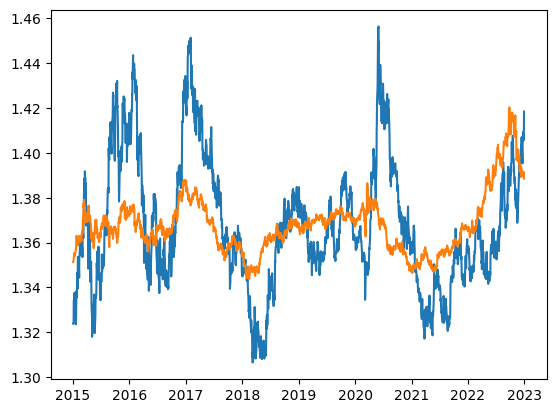

In [183]:
# print model vs actual
model = gamma * x + mu
plt.plot(y)
plt.plot(model)

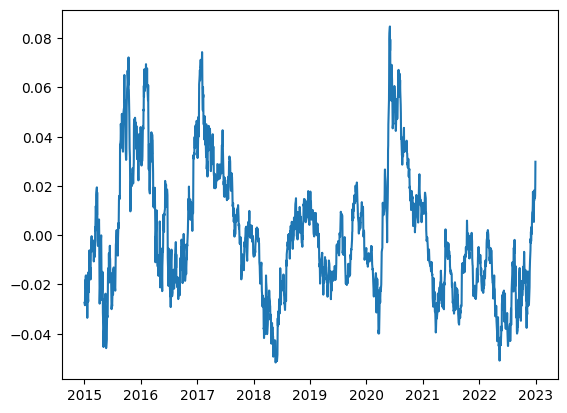

In [184]:
# spread, idk why prof ben coded it like this
df_together["spread"] = (y - gamma * x) - mu
plt.plot(df_together["spread"])

### Note regarding stationarity test

if your test statistic is smaller than critical value for a corresponding significance level, means your series is stationary up to that significance level

e.g. test_statistic = -3.5, 1% significance critval = - 3.3 
your series is stationary with significane level of 99%

another thing to check is p value
p value > 0.05 ; accept null & your series is NOT stationary
p value < 0.05 ; reject null hypothesis & your series IS STATIONARY

In [185]:
result_adf = ts.adfuller(df_together["spread"])
print(f"test statistic {result_adf[0]}")
print(f"p value {result_adf[1]}")
print(f"critical values for test statistic {result_adf[4]}")

test statistic -3.8550463258726557
p value 0.0023917519205319685
critical values for test statistic {'1%': -3.433604305449515, '5%': -2.8629775816425003, '10%': -2.5675353062242845}


## ok now we actually do the portfolio

In [186]:
return_df

,usdsgd,dxy
Date,,
2015-01-02 00:00:00-05:00,NaN,NaN
2015-01-05 00:00:00-05:00,-0.000091,0.003294
2015-01-06 00:00:00-05:00,0.007909,0.001313
2015-01-07 00:00:00-05:00,0.000038,0.004262
2015-01-08 00:00:00-05:00,-0.000210,0.005224
...,...,...
2022-12-23 00:00:00-05:00,0.002704,-0.001149
2022-12-27 00:00:00-05:00,-0.002555,-0.001246
2022-12-28 00:00:00-05:00,0.001295,0.002688


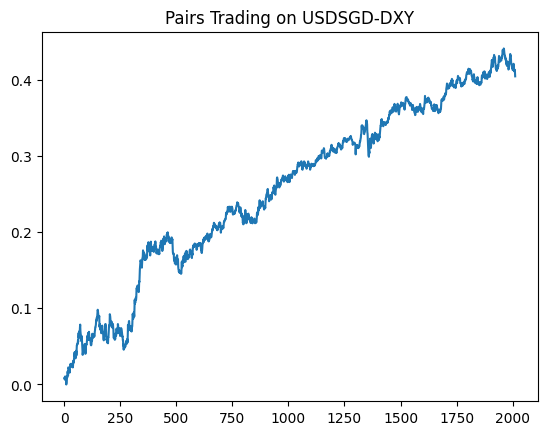

In [187]:
df_together["spread_position"] = 0
df_together.loc[df_together["spread"] > 0, "spread_position"] = -1
df_together.loc[df_together["spread"] < 0, "spread_position"] = 1
df_together["spread_position"] = df_together["spread_position"].shift(1)
df_together["sgd_position"] = df_together["spread_position"]
df_together["dxy_position"] = df_together["spread_position"] * gamma * -1

df_together["dailypnl"] = df_together["sgd_position"] * return_df["usdsgd"].shift(
    -1
) + df_together["dxy_position"] * return_df["dxy"].shift(-1)


df_together["cumpnl"] = df_together["dailypnl"].cumsum()
plt.plot(df_together["cumpnl"].values, label="Pairs Trading on USDSGD-DXY")
plt.title("Pairs Trading on USDSGD-DXY")
plt.show()

In [188]:
df_together

,usdsgd,dxy,spread,spread_position,sgd_position,dxy_position,dailypnl,cumpnl
Date,,,,,,,,
2015-01-02 00:00:00-05:00,1.32390,91.080002,-0.027419,NaN,NaN,NaN,NaN,NaN
2015-01-05 00:00:00-05:00,1.32378,91.379997,-0.028437,1.0,1.0,-0.002994,0.007905,0.007905
2015-01-06 00:00:00-05:00,1.33425,91.500000,-0.018326,1.0,1.0,-0.002994,0.000025,0.007930
2015-01-07 00:00:00-05:00,1.33430,91.889999,-0.019444,1.0,1.0,-0.002994,-0.000226,0.007705
2015-01-08 00:00:00-05:00,1.33402,92.370003,-0.021161,1.0,1.0,-0.002994,0.002443,0.010147
...,...,...,...,...,...,...,...,...
2022-12-23 00:00:00-05:00,1.40920,104.309998,0.018274,-1.0,-1.0,0.002994,0.002551,0.413796
2022-12-27 00:00:00-05:00,1.40560,104.180000,0.015063,-1.0,-1.0,0.002994,-0.001287,0.412509
2022-12-28 00:00:00-05:00,1.40742,104.459999,0.016045,-1.0,-1.0,0.002994,-0.001972,0.410538
